#Proyecto Detección de áreas manipuladas en imágenes RGB.

##importación e instalación de librerias

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install kaggle
!mkdir ~/.kaggle
!cp drive/MyDrive/proyectoIA/kaggle.json /root/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
import kaggle
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

Mounted at /content/drive


##Conjunto de datos "copy-move"

###importación de los datos

In [ ]:
def cargar(n,enl_img,enl_masc1,enl_masc2=None,dim=(224,224),n_inic=0):
  x_train=[]
  y_train=[]
  nombre=os.listdir(enl_img)[n_inic:n_inic+n]
  n=len(nombre)
  for i in range(n):
    img=cv2.imread(enl_img+'/'+nombre[i]).astype(np.float32)/255
    #como la mascara es binaria no es necesario normalizarla
    masc=cv2.imread(enl_masc1+'/'+nombre[i])[:,:,0]
    if enl_masc2!=None:#solo seria verdadero con el dataset copy-move
      masc=masc+cv2.imread(enl_masc2+'/'+nombre[i][:-3]+"jpg")[:,:,0]
    masc=(masc>0.5).astype(np.uint8)
    #recortar imagen
    if np.sum(cv2.resize(masc,dim))/40000<1/5:
      #hallar el tamaño del margen izquierdo
      izq=0
      colum=masc[:,izq]
      while 1 not in colum:
        izq=izq+1
        colum=masc[:,izq]
      #hallar el tamaño del margen derecho
      der=masc.shape[1]-1
      colum=masc[:,der]
      while 1 not in colum:
        der=der-1
        colum=masc[:,der]
      #der=masc.shape[1]-1-der
      #hallar margen superior
      sup=0
      fil=masc[sup,:]
      while 1 not in fil:
        sup=sup+1
        fil=masc[sup,:]
      #hallar margen inferior
      inf=masc.shape[0]-1
      fil=masc[inf,:]
      while 1 not in fil:
        inf=inf-1
        fil=masc[inf,:]
      x_train.append(cv2.resize(img[int(sup*0.8):inf+int((masc.shape[0]-inf-1)*0.2),int(izq*0.8):der+int((masc.shape[1]-der-1)*0.2),:],dim))
      y_train.append(cv2.resize(masc[int(sup*0.8):inf+int((masc.shape[0]-inf-1)*0.2),int(izq*0.8):der+int((masc.shape[1]-der-1)*0.2)],dim))
    else:
      x_train.append(cv2.resize(img,dim))
      y_train.append(cv2.resize(masc,dim))
  return np.array(x_train,dtype=np.float32),np.array(y_train,dtype=np.uint8)

In [ ]:
carpeta="copy"
#verificamos que la carpeta existo o no
if not os.path.exists(carpeta):
#si no existe la crea
    os.makedirs(carpeta)
# si la carpeta existe y esta vacia descarga el dataset
if not os.listdir(carpeta):
    !kaggle datasets download -d defactodataset/defactocopymove --unzip  -p $carpeta

100% 9.58G/9.60G [01:51<00:00, 101MB/s]
100% 9.60G/9.60G [01:51<00:00, 92.3MB/s]


Previsualización de los datos

###preprocesamiento

In [ ]:
os.chdir("/content/copy")
n=2000#cantidad de imagenes a carguar
np.random.seed(0)
random.seed(0)
carp_img="copymove_img/img"
carp_donor="copymove_annotations/donor_mask"
carp_probe="copymove_annotations/probe_mask"
#carguar los datos de entrenamiento
x_train,y_train=cargar(
    n,
    carp_img,
    carp_donor,
    carp_probe,
)
#carguar datos de validación
n_test=int(len(x_train)*0.2)
x_valid,y_valid=cargar(
    n_test,
    carp_img,
    carp_donor,
    carp_probe,
    n_inic=n+1
)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(2000, 224, 224, 3)
(2000, 224, 224)
(400, 224, 224, 3)
(400, 224, 224)


elección de las dimensiones y cantidad de imágenes a utilizar (tanto para entrenamiento cómo para testeo)

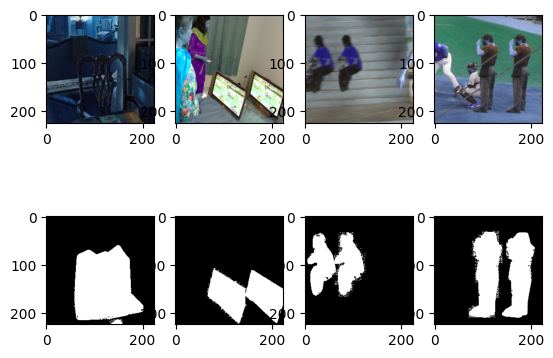

In [ ]:
muest=4
fig,axs=plt.subplots(2,muest)
for i in range(muest):
  axs[0,i].imshow((x_train[i]*255).astype(np.uint8))
  axs[1,i].imshow(y_train[i],cmap="gray")

balanceo de datos

In [ ]:
print(np.mean(y_train))

0.1854310825892857


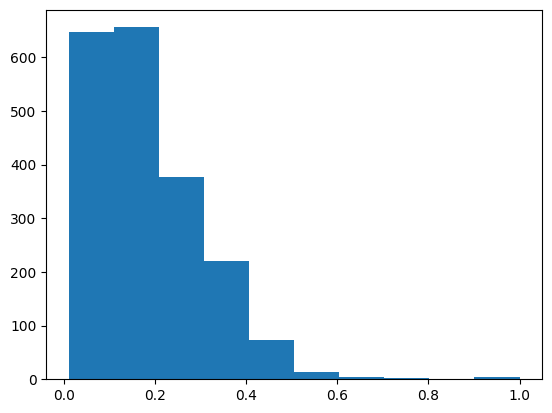

In [ ]:
#porcentaje de pixeles alterados
alt=np.empty(len(y_train))
for i in range(len(y_train)):
  alt[i]=np.sum(y_train[i])/np.size(y_train[i])
plt.hist(alt)
plt.show()

###Modelo

carguar modelo pre-entrenado

definir modelo

In [ ]:
filt_inic=16
def dobleConv(filt):
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(filt,(3,3),padding="same",activation="relu"),
      tf.keras.layers.Conv2D(filt,(3,3),padding="same",activation="relu")
  ])
#codificador
entr=tf.keras.layers.Input(shape=x_train[0].shape)
cod1=dobleConv(filt_inic)(entr)
max1=tf.keras.layers.MaxPool2D(strides=(2,2),padding="same")(cod1)#240

cod2=dobleConv(filt_inic*2)(max1)
max2=tf.keras.layers.MaxPool2D(strides=(2,2),padding="same")(cod2)#120

cod3=dobleConv(filt_inic*4)(max2)
max3=tf.keras.layers.MaxPool2D(strides=(2,2),padding="same")(cod3)#60

cod4=dobleConv(filt_inic*8)(max3)
max4=tf.keras.layers.MaxPool2D(strides=(2,2),padding="same")(cod4)#30

cod5=dobleConv(filt_inic*16)(max4)#15
max5=tf.keras.layers.MaxPool2D(strides=(2,2),padding="same")(cod5)
#embebido
emb=dobleConv(filt_inic*32)(max5)
#decodificador
tras5=tf.keras.layers.Conv2DTranspose(filt_inic*16,(3,3),(2,2),"same",activation="relu")(emb)
deco5=dobleConv(filt_inic*16)(tf.keras.layers.concatenate([tras5,cod5]))

tras4=tf.keras.layers.Conv2DTranspose(filt_inic*8,(3,3),(2,2),"same",activation="relu")(deco5)
deco4=dobleConv(filt_inic*8)(tf.keras.layers.concatenate([tras4,cod4]))

tras3=tf.keras.layers.Conv2DTranspose(filt_inic*4,(3,3),(2,2),"same",activation="relu")(deco4)
deco3=dobleConv(filt_inic*4)(tf.keras.layers.concatenate([tras3,cod3]))

tras2=tf.keras.layers.Conv2DTranspose(filt_inic*2,(3,3),(2,2),"same",activation="relu")(deco3)
deco2=dobleConv(filt_inic*2)(tf.keras.layers.concatenate([tras2,cod2]))

tras1=tf.keras.layers.Conv2DTranspose(filt_inic,(3,3),(2,2),"same",activation="relu")(deco2)
deco1=dobleConv(filt_inic)(tf.keras.layers.concatenate([tras1,cod1]))
#salida
sal=tf.keras.layers.Conv2D(1,(1,1),padding="same",activation="sigmoid")(deco1)
model=tf.keras.models.Model(inputs=[entr],outputs=[sal])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 16  2768        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 112, 112, 16  0           ['sequential[0][0]']             
                                )                                                             

In [ ]:
earlystopper = EarlyStopping(patience=5, verbose=1)#patience=3, si van 3 veces sin cambiar; se detiene el entrenamiento
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.8),metrics=[tf.keras.metrics.Recall(),"accuracy"])

In [ ]:
os.chdir("/content/drive/MyDrive/proyectoIA")
hist=model.fit(x_train,y_train,batch_size=30,epochs=100,validation_data=(x_valid,y_valid),callbacks=[earlystopper],shuffle="True")

Epoch 1/100
67/67 [==============================] - ETA: 0s - loss: 0.0347 - recall_2: 0.8061 - accuracy: 0.7957
Epoch 1: val_loss improved from inf to 0.04438, saving model to copyPaste2.h5
67/67 [==============================] - 86s 267ms/step - loss: 0.0347 - recall_2: 0.8061 - accuracy: 0.7957 - val_loss: 0.0444 - val_recall_2: 0.7063 - val_accuracy: 0.7469
Epoch 2/100
67/67 [==============================] - ETA: 0s - loss: 0.0315 - recall_2: 0.8289 - accuracy: 0.8185
Epoch 2: val_loss did not improve from 0.04438
67/67 [==============================] - 17s 249ms/step - loss: 0.0315 - recall_2: 0.8289 - accuracy: 0.8185 - val_loss: 0.0468 - val_recall_2: 0.6678 - val_accuracy: 0.7531
Epoch 3/100
67/67 [==============================] - ETA: 0s - loss: 0.0286 - recall_2: 0.8548 - accuracy: 0.8388
Epoch 3: val_loss did not improve from 0.04438
67/67 [==============================] - 17s 247ms/step - loss: 0.0286 - recall_2: 0.8548 - accuracy: 0.8388 - val_loss: 0.0556 - val_reca

Datos de testeo

In [ ]:
os.chdir("/content/copy")
x_test,y_test=cargar(
    int(len(x_train)),
    "copymove_img/img",
    "copymove_annotations/donor_mask",
    "copymove_annotations/probe_mask",
    n_inic=len(x_train)+2
)

In [ ]:
model.evaluate(x_test,y_test)

63/63 [==============================] - 5s 74ms/step - loss: 0.0312 - recall_2: 0.8700 - accuracy: 0.8018


[0.031195977702736855, 0.8699870705604553, 0.8018009662628174]

In [ ]:
pred=model.predict(np.array(x_test[0:5],dtype=np.float32))
pred=pred>0.5
pred=pred.astype(np.uint8)

1/1 [==============================] - 2s 2s/step


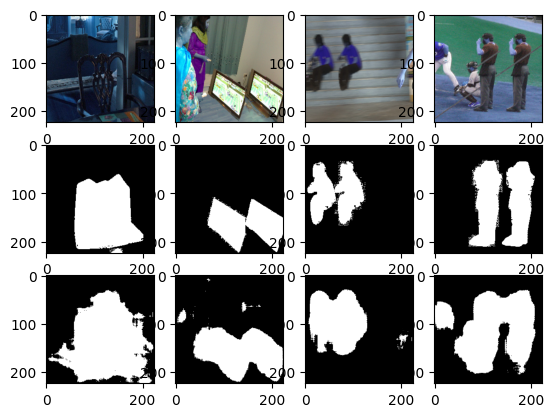

In [ ]:
muest=4
fig,axs=plt.subplots(3,muest)
for i in range(muest):
  axs[0,i].imshow((x_test[i]*255).astype(np.uint8))
  axs[1,i].imshow(y_test[i],cmap="gray")
  axs[2,i].imshow(pred[i],cmap="gray")

matriz de confusion

In [ ]:
import pandas as pd
mat=pd.DataFrame({"reales":[0,1],0:[0,0],1:[0,0]})
for ind_masc in range(len(pred)):
  for i in range(224):
    for j in range(224):
      mat[int(pred[ind_masc,i,j])][int(y_test[ind_masc,i,j])]=mat[int(pred[ind_masc,i,j])][int(y_test[ind_masc,i,j])]+1
mat.head()

,reales,0,1
0,0,171695,42756
1,1,6552,29877
